In [9]:
using Plots;
gadfly();

In [10]:
include("../fdtd/update.jl");
include("../fdtd/sources.jl");
include("../fdtd/boundaries.jl");
using update;
using sources;

In [78]:
#Global parameters
size = 400;
endTime = 4000;
num_snaps = 100;
snap_step = div(endTime, num_snaps);

# Incident
inc_pos = 100;

# Material
n1 = 2;
n2 = 2;
eps1 = n1^2;

wavelength = round(Integer, size / 5);
q_wavelength = round(Integer, wavelength * n1 / n2 / 2);
n2 = (wavelength * n1) / (q_wavelength * 2.);

eps2 = n2^2;
#Grid

# Magnetic
hy = zeros(size-1);
mu = ones(size-1);

chyh = ones(size);
chye = ones(size);


# Electric
ez = zeros(size);
eps = ones(size) * eps1;

cezh = ones(size);
ceze = ones(size);


#for i in 110:170
#    eps[i] = eps1;
#end
for i in div(size, 2):div(size, 2)+q_wavelength-1
    # eps[i] = eps2;
end

rightBound = boundaries.setup_first_order_abc(eps, mu, size, true)
leftBound = boundaries.setup_first_order_abc(eps, mu, 1, false)

# output params
ez_snapshot = Array{Any}(num_snaps);
hy_snapshot = Array{Any}(num_snaps);

In [83]:
# Time steps

for time in 1:endTime
    # Incident
    ez_inc = sin(2*pi/(wavelength) * (time-1))*exp(-3000/time);
    hy_inc = sin(2*pi/(wavelength) * (time-2))*exp(-3000/time);
    
    #
    # Magnetic
    #
        
    # Interior update
    update.update_magnetic_field!(ez, hy, mu, chyh, chye);    
    
    # TFSF
    hy[inc_pos-1] -= hy_inc / globals.imp0;
    
    #
    # Electric
    #
       
    # Interior update
    update.update_electric_field!(ez, hy, eps, cezh, ceze);
    
    # ABC
    boundaries.first_order_diff_abc!(ez, leftBound)
    boundaries.first_order_diff_abc!(ez, rightBound)
    
    # TFSF
    ez[inc_pos] += ez_inc / sqrt( eps[inc_pos] * mu[inc_pos])
 
    # Snapshots for animation
    if mod(time, snap_step) == 0
        ez_snapshot[div(time,snap_step)] = (time, copy(ez))
        hy_snapshot[div(time,snap_step)] = (time, copy(hy).*globals.imp0)        
    end
    
end

In [84]:
anim = Animation()

for i = 1:num_snaps
    p = plot(1:size, ez_snapshot[i][2], lab="Ez")
    
    time = ez_snapshot[i][1]
    plot!(ann=[(0.8*size, 1.5, "time =$time")])
    plot!([size/2, size/2], [-2, 2])
    plot!([size/2+q_wavelength, size/2+q_wavelength], [-2, 2])
    
    plot!(xlims=(1, size), ylims=(-2, 2))
    frame(anim, p)
end
gif(anim, "./Task3/Half_Wavelength_Reflection_TFSF.gif", fps=15)

INFO: Saved animation to /media/storage/Documents/Github/students-2016/1_fdtd/Tasks/Task3/Half_Wavelength_Reflection_TFSF.gif


Plots.AnimatedGif("/media/storage/Documents/Github/students-2016/1_fdtd/Tasks/Task3/Half_Wavelength_Reflection_TFSF.gif")

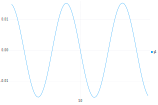

In [81]:
plot(1:inc_pos-2, ez[1:inc_pos-2])
plot!(xlims=(1, inc_pos-2), ylims=(maximum(ez[1:inc_pos-2]),minimum(ez[1:inc_pos-2])))

In [82]:
maximum(abs(ez[1:inc_pos-2]))

0.01535105164067894